In [1]:
"""
Notebook Matrix Profile – ampiimts Python 3.11 package

Goal:
From pre processing signal with original value, normalize value, timestamp. 
We identify discord and motifs with a fix window on matrix profile methode (stumpy.maamp)
"""
import pandas as pd
import ampiimts
import time
import os 

In [2]:
#import files
folder = '../../dataset/pollution'
pds = []
with os.scandir(folder) as entries:
    for entry in entries:
        if entry.is_file() and entry.name.endswith('csv') and not entry.name.startswith('pollutionData'):
            # list of sensors with some parameters -> list[pd.DataFrame[timestamp, value1, value2, etc..., latitude, longitude]]) 
            pds.append(pd.read_csv(folder+'/'+entry.name))
len(pds)
# pds = pds[:10]

5

Best consensus window size(s): [(2016, '168h', np.float32(0.014613318), np.float64(0.0))]
Best consensus window size(s): [(2016, '168h', np.float32(0.014613318), np.float64(0.0))]
Best consensus window size(s): [(2016, '168h', np.float32(0.014613318), np.float64(0.0))]
Most frequent window size after 3 runs (all dfs): 168h


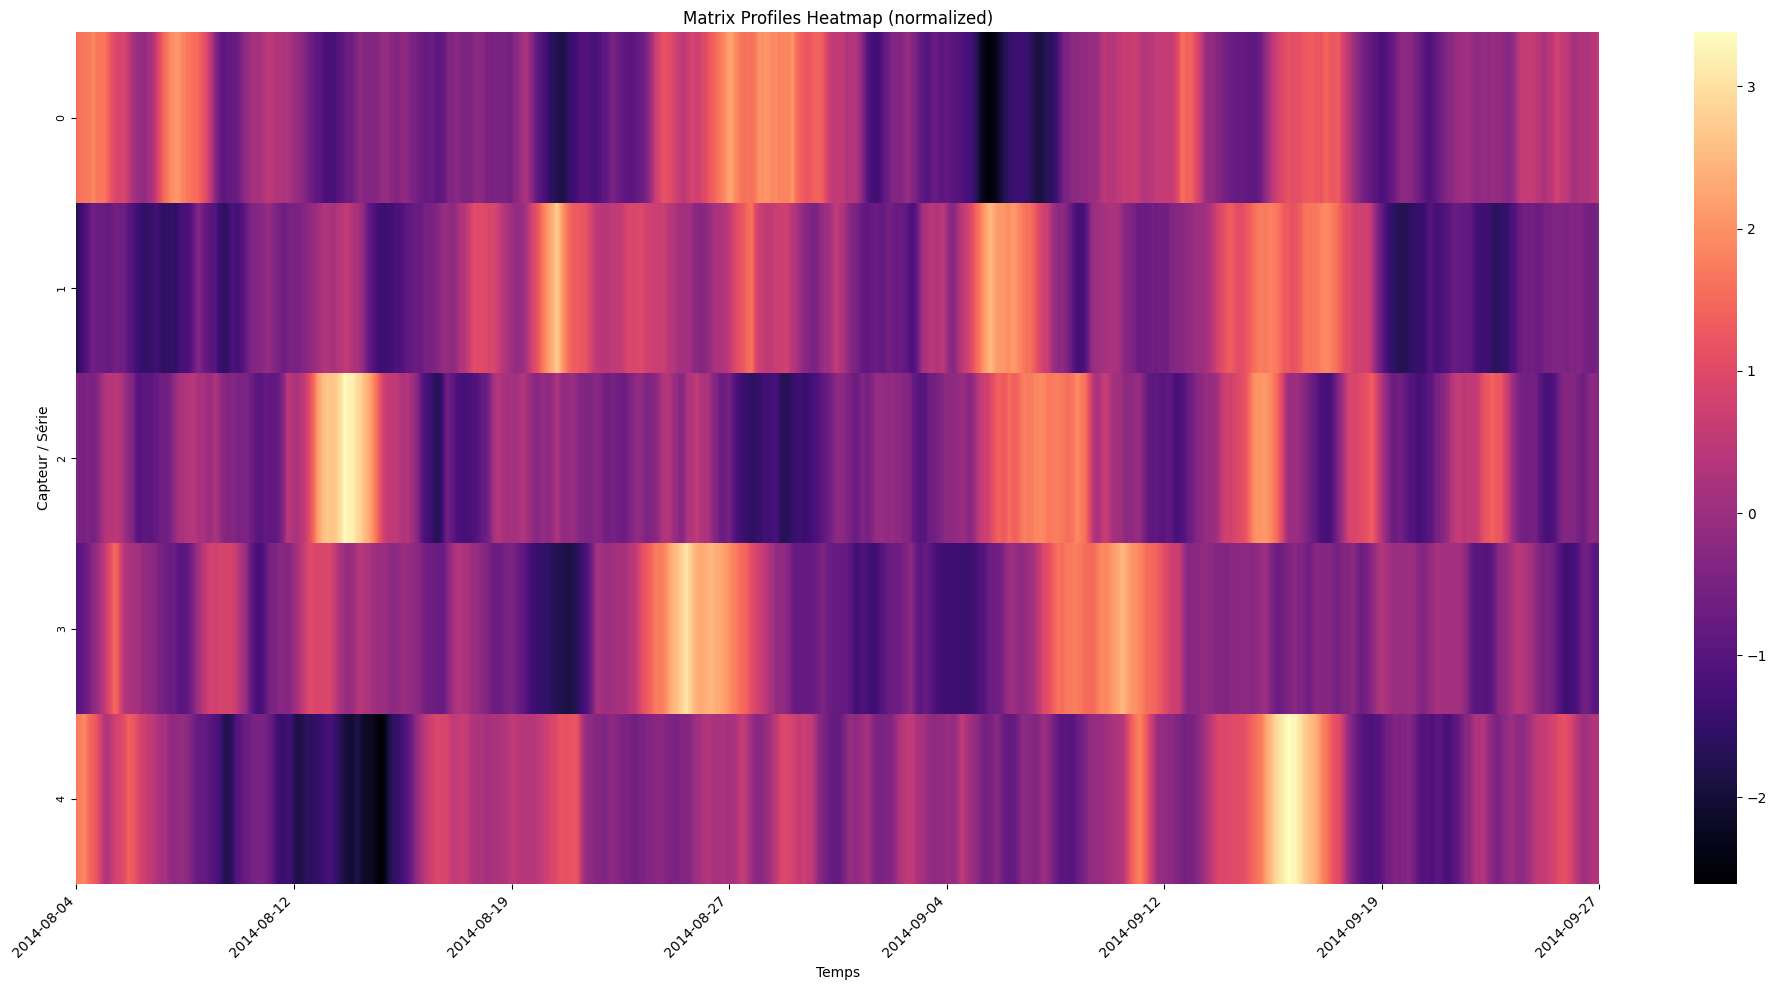

In [3]:
pds_normalized = ampiimts.pre_processed(pds, sort_by_variables=False)
matrix_profiles = ampiimts.matrix_profile(pds_normalized)
ampiimts.plot_matrix_profiles_heatmap(matrix_profiles, 
                            time_index=matrix_profiles[0].index, 
                            capteur_labels=[f"Capteur {i+1}" for i in range(len(matrix_profiles))],
                            cmap="magma")  # Ou "viridis", "cubehelix", etc.


Best consensus window size(s): [(2016, '168h', np.float32(0.012832278), np.float64(0.0))]
Best consensus window size(s): [(2016, '168h', np.float32(0.013434032), np.float64(0.0))]
Best consensus window size(s): [(2016, '168h', np.float32(0.01789747), np.float64(0.0))]
Best consensus window size(s): [(2016, '168h', np.float32(0.014055161), np.float64(0.0))]
Best consensus window size(s): [(2016, '168h', np.float32(0.013361371), np.float64(0.0))]


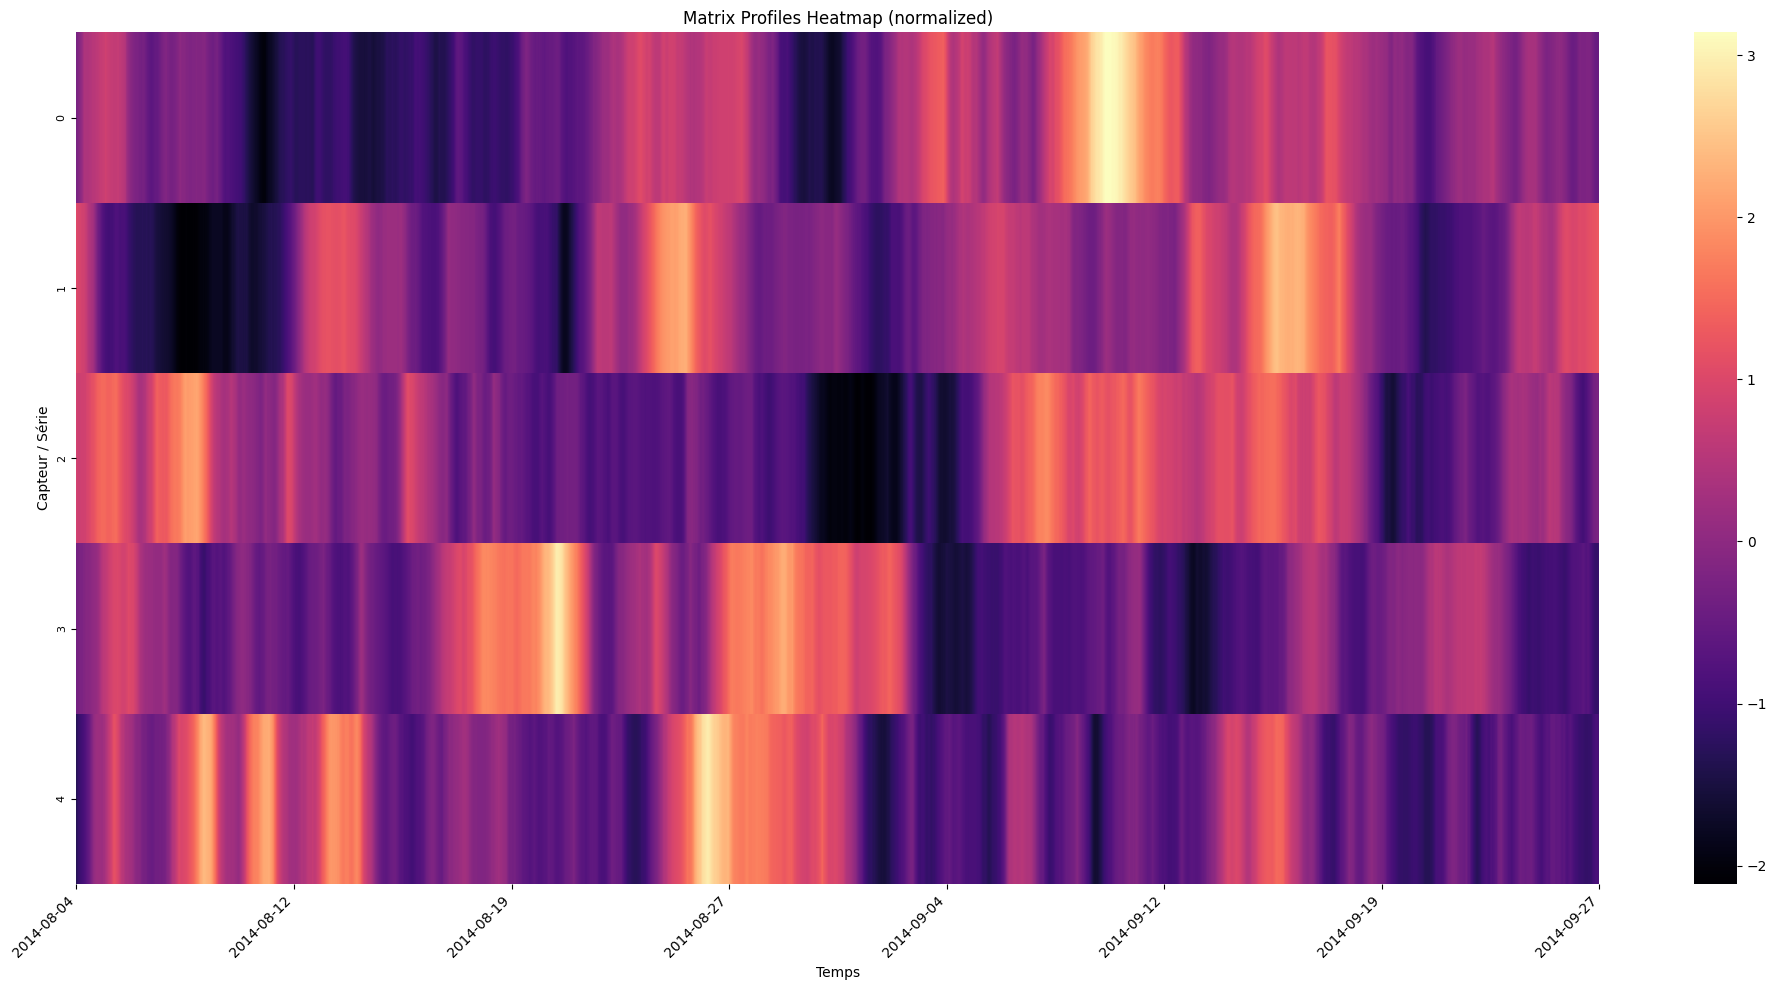

In [4]:
pds_normalized = ampiimts.pre_processed(pds, sort_by_variables=True)
matrix_profiles = ampiimts.matrix_profile(pds_normalized)
ampiimts.plot_matrix_profiles_heatmap(matrix_profiles, 
                            time_index=matrix_profiles[0].index, 
                            capteur_labels=[f"Capteur {i+1}" for i in range(len(matrix_profiles))],
                            cmap="magma")  # Ou "viridis", "cubehelix", etc.


In [11]:
import numpy as np

def extract_discords(df_profile, top_k=3):
    # df_profile doit avoir une colonne 'value'
    idx_top = np.argsort(df_profile['value'].values)[-top_k:]
    return df_profile.index[idx_top], df_profile['value'].values[idx_top]


def extract_unique_motifs(df_profile, window_size, top_k=3, min_sep=None):
    """
    Extrait les top_k motifs récurrents, mais en ignorant les doublons très proches.
    - min_sep : séparation minimale (en points) entre motifs (par défaut = window_size)
    """
    values = df_profile['value'].values
    indices = np.argsort(values)
    motifs = []
    motif_idxs = []
    if min_sep is None:
        min_sep = window_size
    for idx in indices:
        # Vérifie que ce motif n'est pas trop proche d'un déjà pris
        if all(abs(idx - mi) > min_sep for mi in motif_idxs):
            t1 = df_profile.index[idx]
            t2 = df_profile.index[int(df_profile.iloc[idx]['index_2'])]
            motifs.append((t1, t2, values[idx]))
            motif_idxs.append(idx)
        if len(motifs) >= top_k:
            break
    return motifs

import matplotlib.pyplot as plt

def plot_discords_on_signal(signal, profile, discord_indices, window_size):
    plt.figure(figsize=(15,4))
    plt.plot(signal.index, signal.values, label="Signal original")
    for idx in discord_indices:
        start = max(0, idx - window_size//2)
        end = min(len(signal), idx + window_size//2)
        plt.axvspan(signal.index[start], signal.index[end-1], color='red', alpha=0.3)
    plt.legend()
    plt.title("Discords (anomalies)")
    plt.show()

def plot_motif_pairs(signal, idx1, idx2, window_size):
    plt.figure(figsize=(15,4))
    plt.plot(signal.index, signal.values, label="Signal original", color='gray')
    # Affiche les 2 motifs superposés
    for idx, col in zip([idx1, idx2], ['blue', 'green']):
        start = max(0, idx - window_size//2)
        end = min(len(signal), idx + window_size//2)
        plt.plot(signal.index[start:end], signal.values[start:end], color=col, lw=2)
    plt.legend()
    plt.title("Motifs similaires trouvés")
    plt.show()



In [6]:
matrix_profiles[1].head(-1)

,value,index_1,index_2,index_3
2014-08-04 12:05:00,2333.560096,0,884,NaN
2014-08-04 12:10:00,2332.256006,1,886,NaN
2014-08-04 12:15:00,2331.051952,2,886,NaN
2014-08-04 12:20:00,2329.864233,3,887,NaN
2014-08-04 12:25:00,2328.823139,4,888,NaN
...,...,...,...,...
2014-09-27 11:40:00,2391.273361,15547,14040,NaN
2014-09-27 11:45:00,2391.924265,15548,14041,NaN
2014-09-27 11:50:00,2392.747483,15549,14042,NaN
2014-09-27 11:55:00,2393.394381,15550,14043,NaN


Variable 0 - Capteur 'carbon_monoxide_1': Discords aux instants [Timestamp('2014-09-10 01:25:00'), Timestamp('2014-09-10 01:30:00'), Timestamp('2014-09-10 01:35:00')]


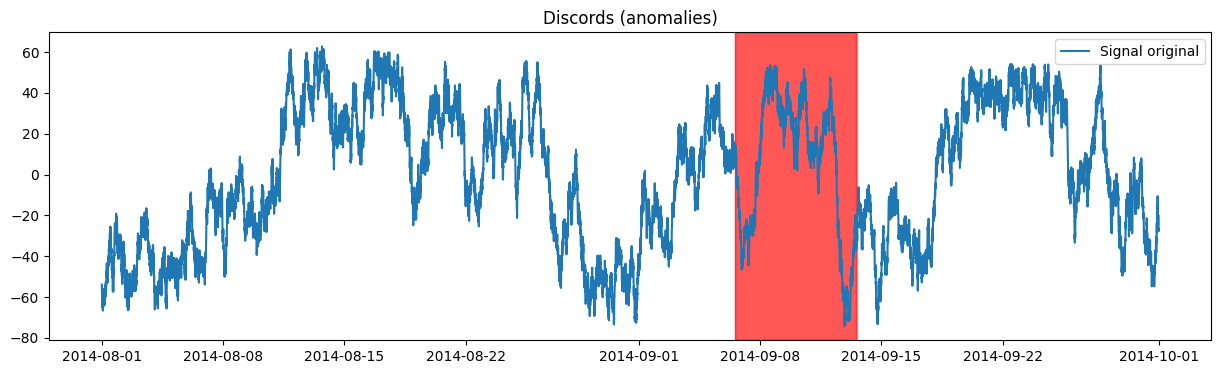

Variable 1 - Capteur 'nitrogen_dioxide_1': Discords aux instants [Timestamp('2014-09-16 01:55:00'), Timestamp('2014-09-16 02:00:00'), Timestamp('2014-09-16 01:50:00')]


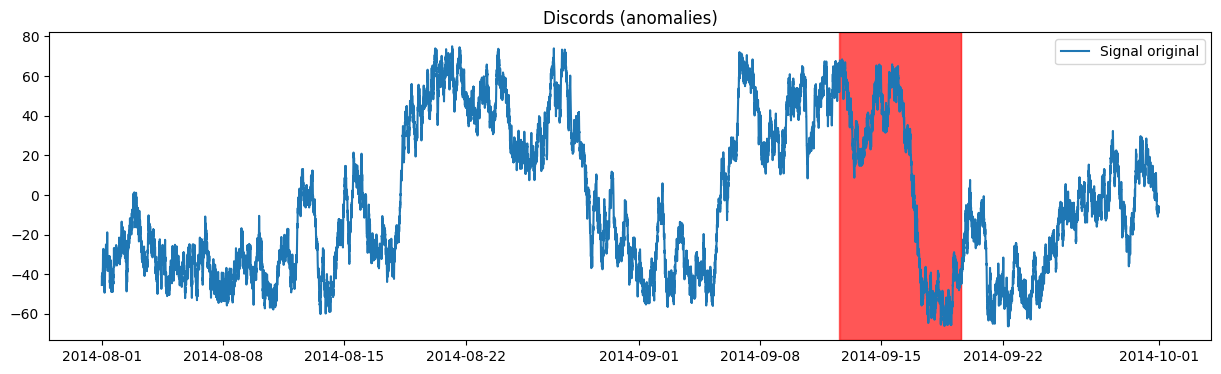

Variable 2 - Capteur 'ozone_1': Discords aux instants [Timestamp('2014-08-08 18:15:00'), Timestamp('2014-08-08 18:05:00'), Timestamp('2014-08-08 18:00:00')]


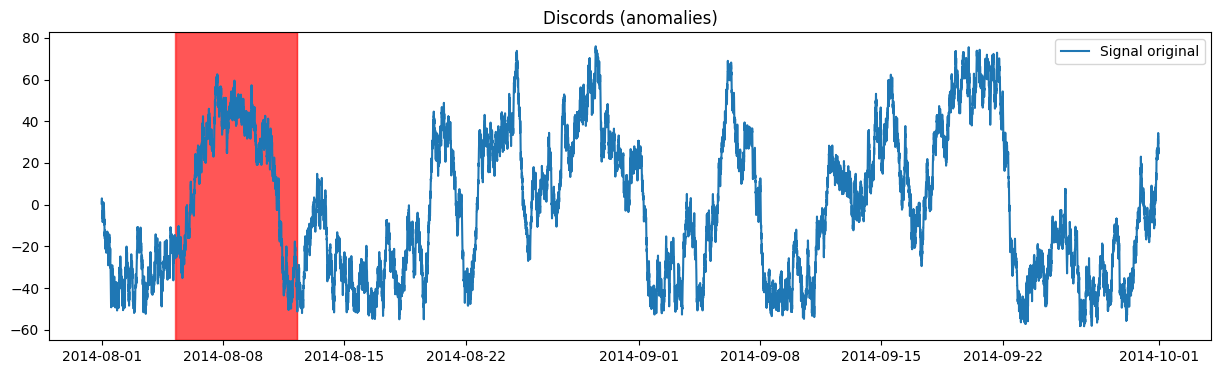

Variable 3 - Capteur 'particullate_matter_1': Discords aux instants [Timestamp('2014-08-21 12:40:00'), Timestamp('2014-08-21 12:35:00'), Timestamp('2014-08-21 12:30:00')]


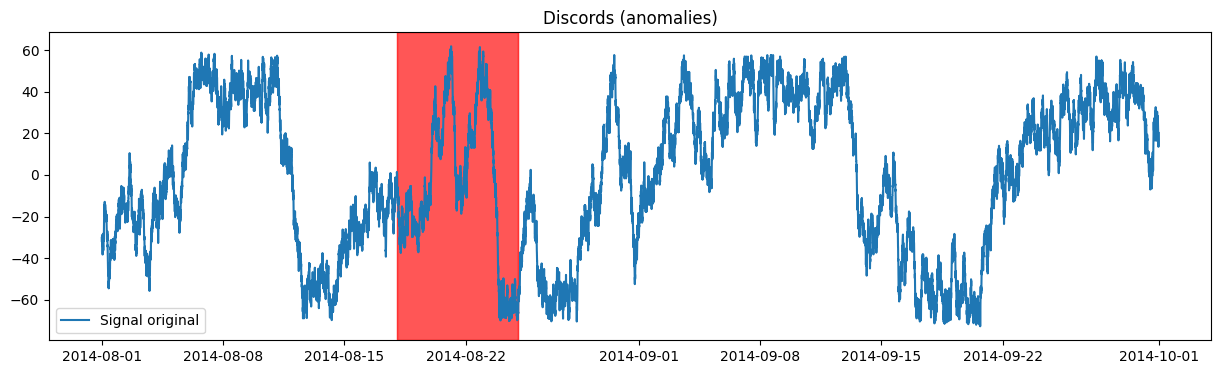

Variable 4 - Capteur 'sulfure_dioxide_1': Discords aux instants [Timestamp('2014-08-26 21:15:00'), Timestamp('2014-08-26 21:25:00'), Timestamp('2014-08-26 21:20:00')]


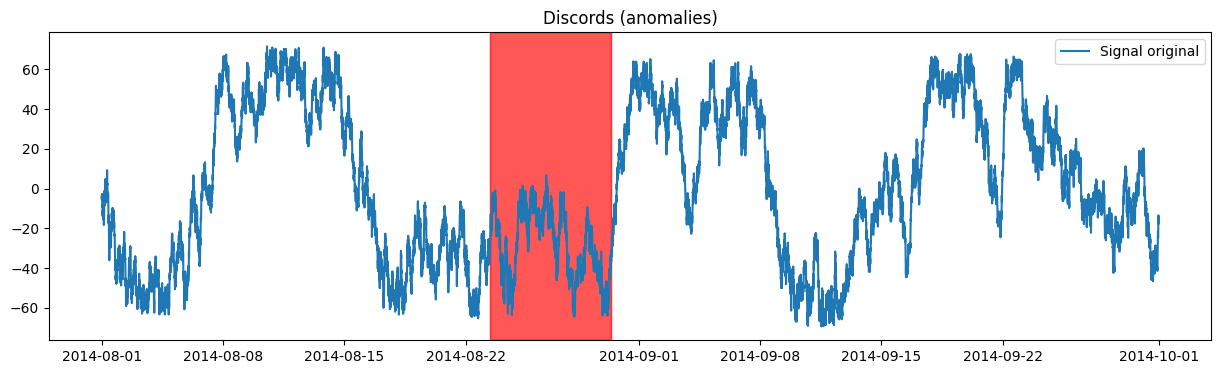

In [12]:
window_size = 2016  # adapte à ton contexte
for var_idx, (signal_df, prof) in enumerate(zip(pds_normalized  , matrix_profiles)):
    capteur_col = signal_df.columns[1]
    signal = signal_df[capteur_col]
    # Assure-toi d'avoir un DatetimeIndex
    if not isinstance(signal.index, pd.DatetimeIndex):
        signal.index = pd.to_datetime(signal.index)
    idx_discords, discord_values = extract_discords(prof, top_k=3)
    # Obtenir les positions dans le profile
    discord_profile_indices = [prof.index.get_loc(ts) for ts in idx_discords]
    # Calculer les positions centrées dans le signal
    center_indices = np.arange(len(signal) - window_size + 1) + window_size // 2
    center_indices = center_indices[center_indices < len(signal)]
    signal_indices = [center_indices[di] for di in discord_profile_indices]
    print(f"Variable {var_idx} - Capteur '{capteur_col}': Discords aux instants {list(idx_discords)}")
    plot_discords_on_signal(signal, prof, signal_indices, window_size)


Variable 0 ('carbon_monoxide_1') : Motif à 2014-08-11 03:50:00 et 2014-08-31 01:30:00 (dist=1773.37)


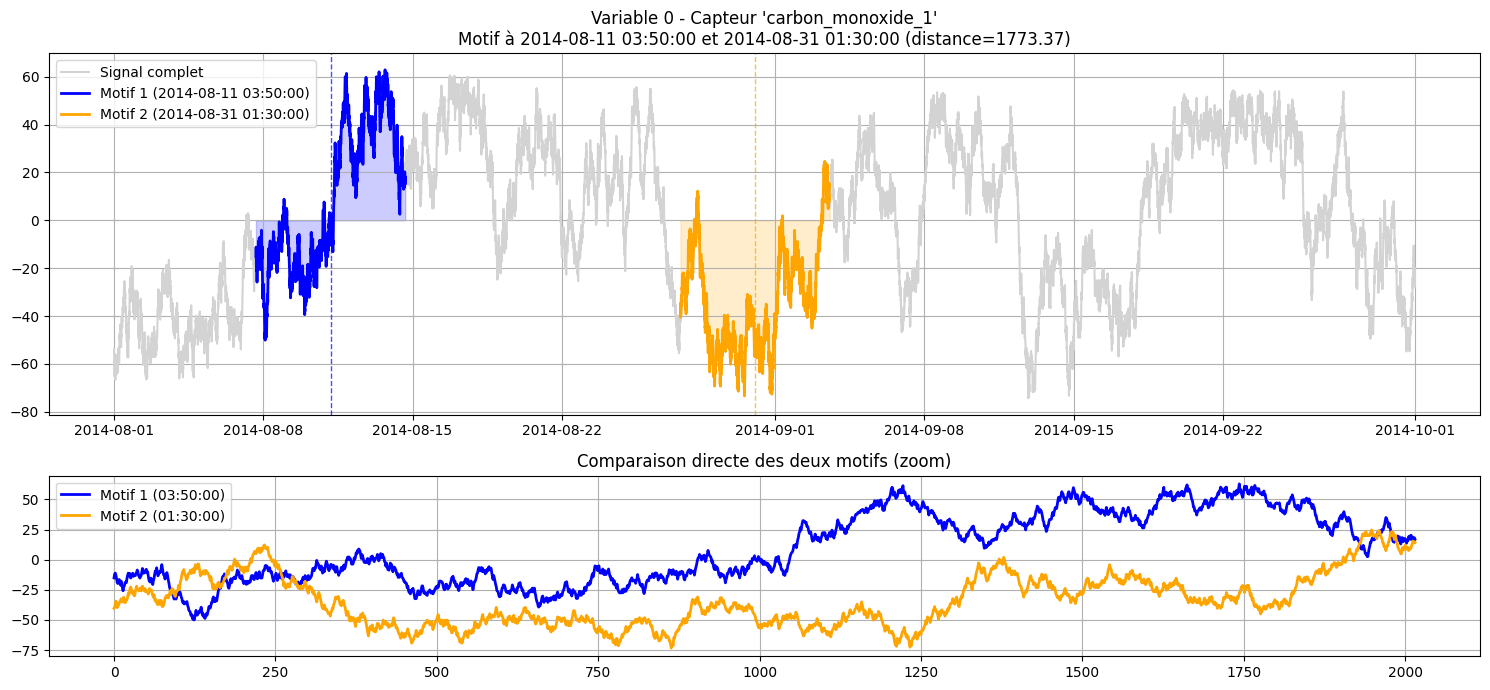

Variable 0 ('carbon_monoxide_1') : Motif à 2014-08-31 07:30:00 et 2014-08-15 01:20:00 (dist=1815.66)


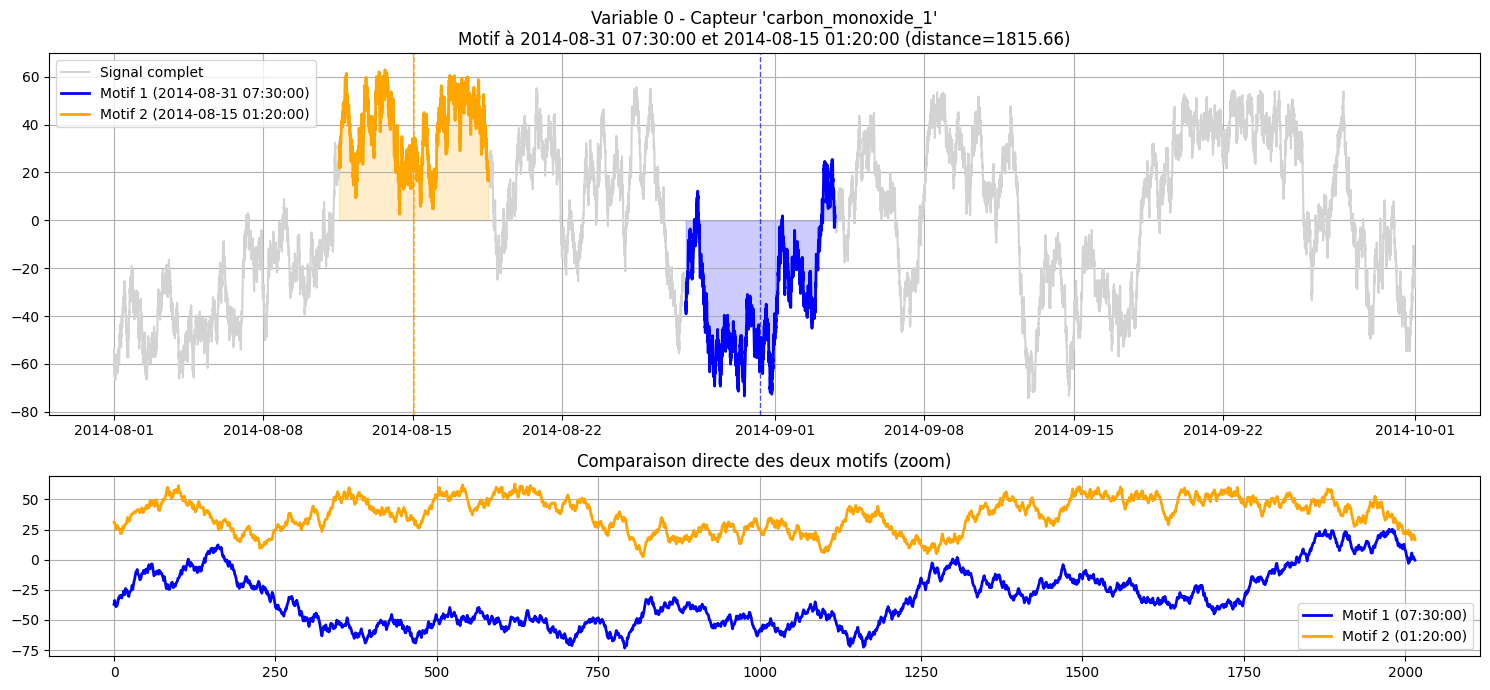

Variable 0 ('carbon_monoxide_1') : Motif à 2014-08-18 23:50:00 et 2014-08-30 02:25:00 (dist=1913.18)


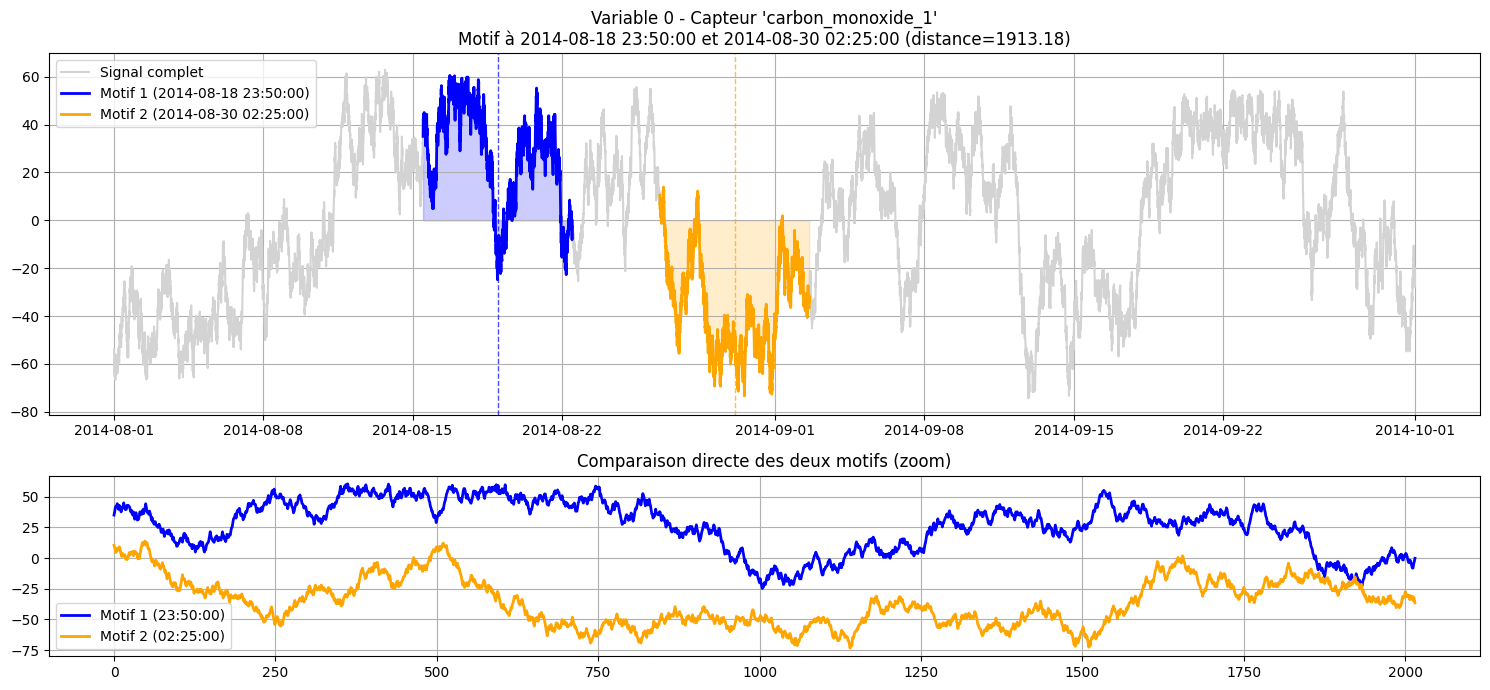

Variable 1 ('nitrogen_dioxide_1') : Motif à 2014-08-08 07:10:00 et 2014-08-15 05:15:00 (dist=1614.75)


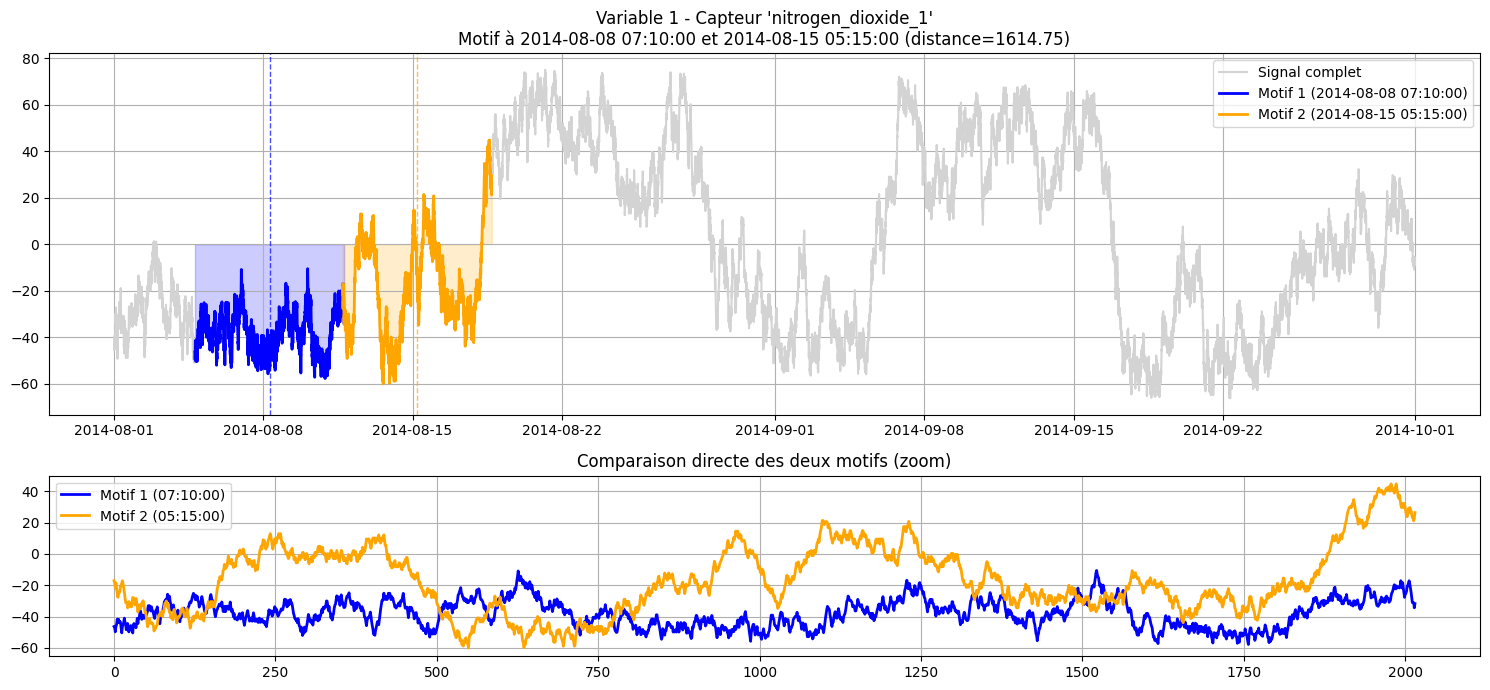

Variable 1 ('nitrogen_dioxide_1') : Motif à 2014-08-21 19:55:00 et 2014-09-13 10:45:00 (dist=1679.63)


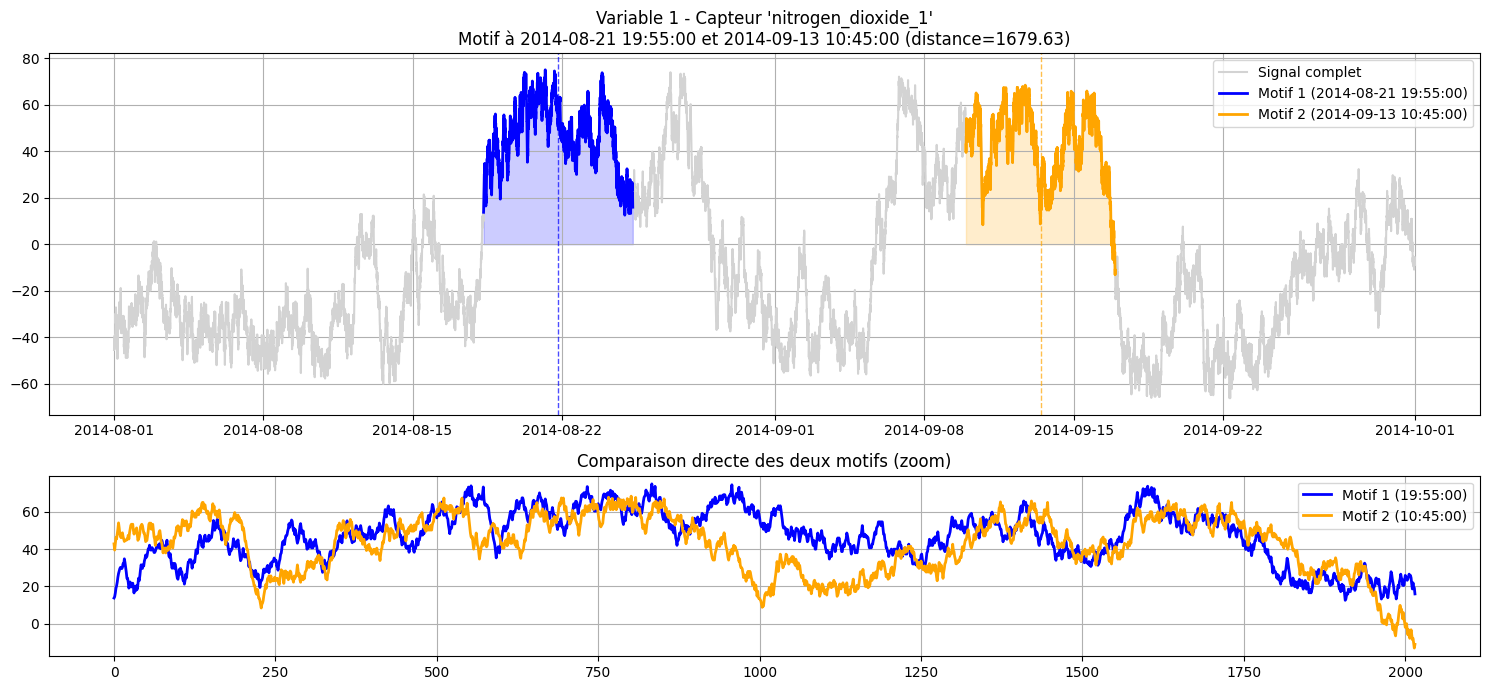

Variable 1 ('nitrogen_dioxide_1') : Motif à 2014-09-21 08:05:00 et 2014-09-01 18:30:00 (dist=1787.74)


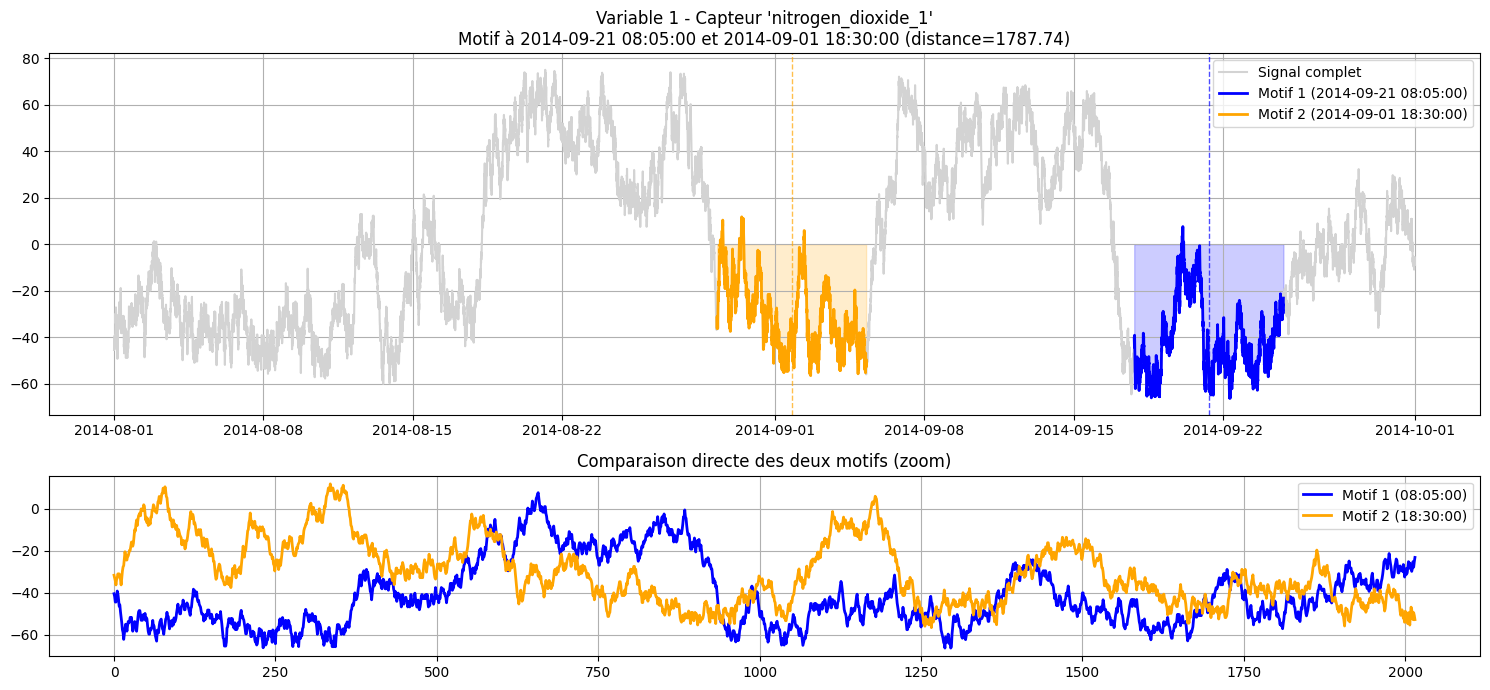

Variable 2 ('ozone_1') : Motif à 2014-09-01 04:50:00 et 2014-08-21 23:55:00 (dist=1746.69)


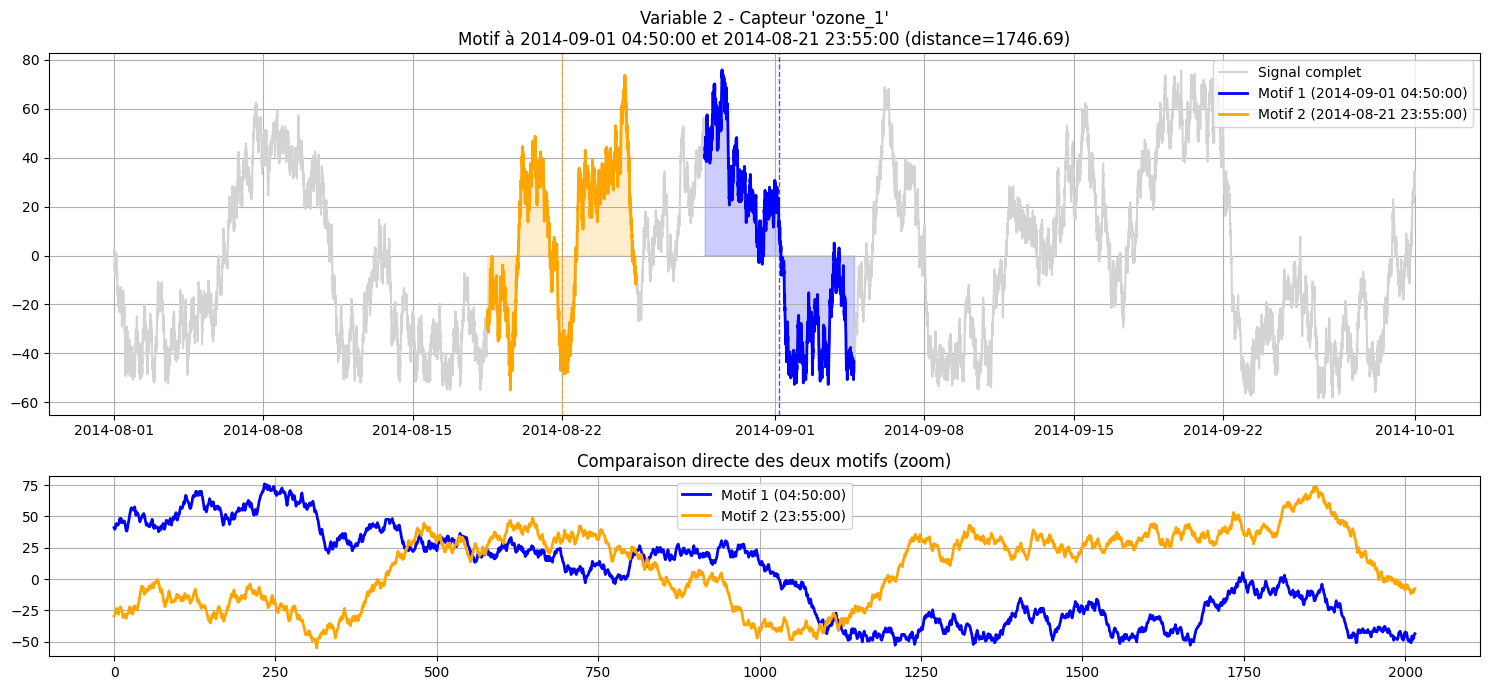

Variable 2 ('ozone_1') : Motif à 2014-09-20 04:30:00 et 2014-09-24 00:35:00 (dist=1832.79)


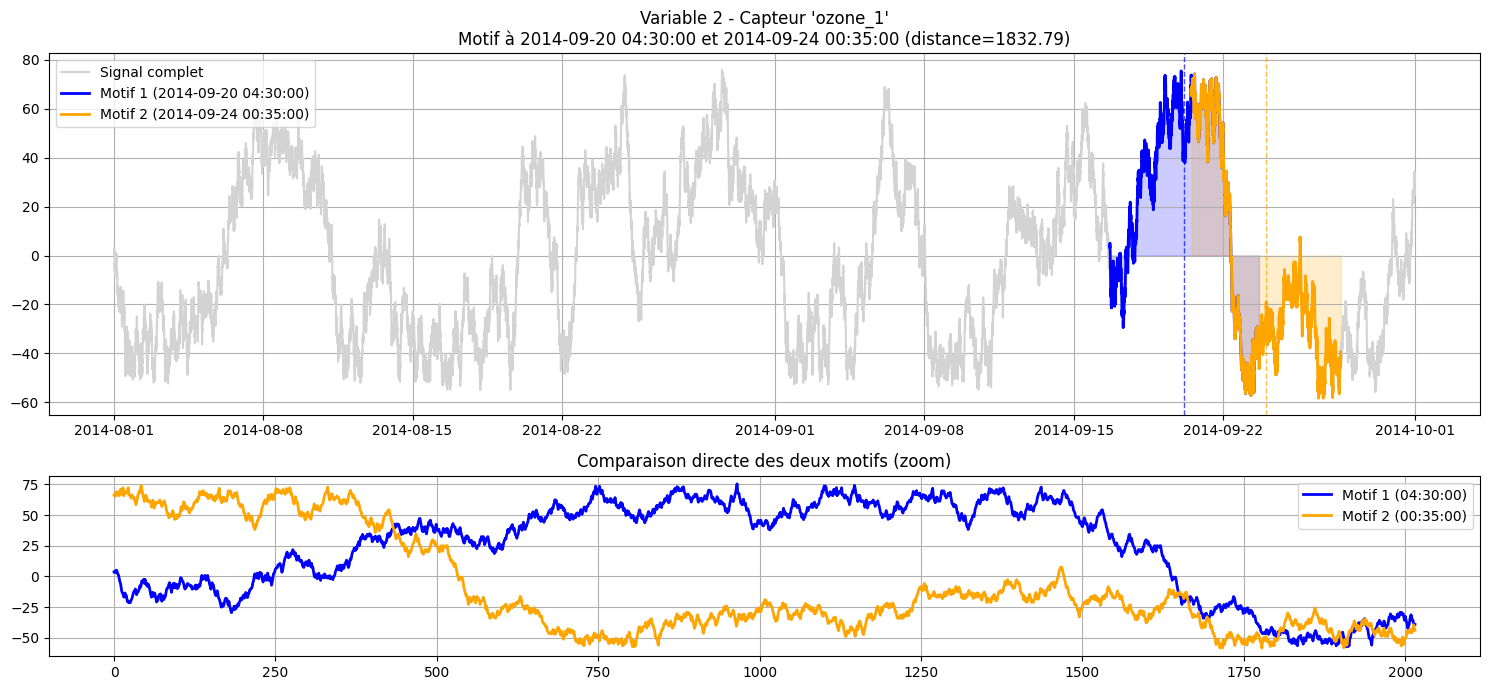

Variable 2 ('ozone_1') : Motif à 2014-08-22 16:45:00 et 2014-09-04 04:35:00 (dist=1944.07)


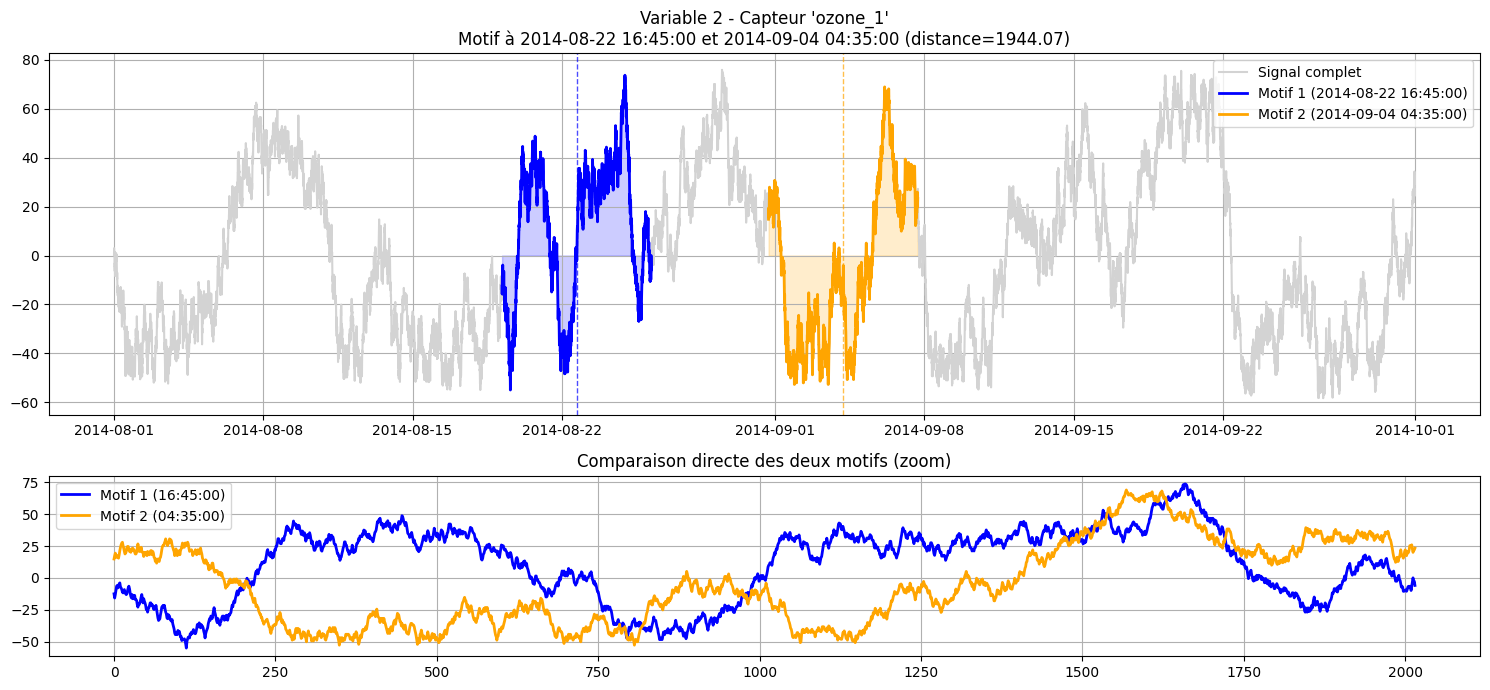

Variable 3 ('particullate_matter_1') : Motif à 2014-09-13 02:45:00 et 2014-09-05 15:30:00 (dist=1810.81)


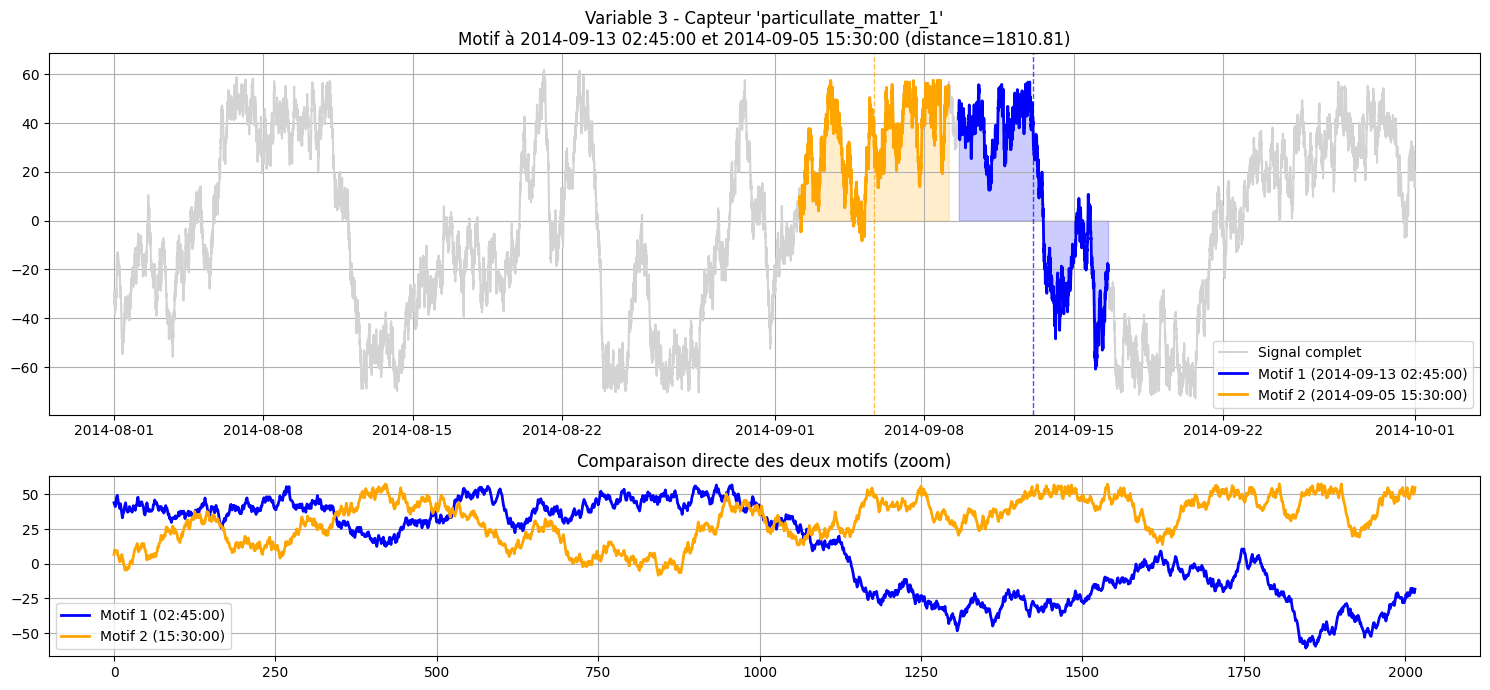

Variable 3 ('particullate_matter_1') : Motif à 2014-09-04 02:40:00 et 2014-09-24 09:40:00 (dist=1842.05)


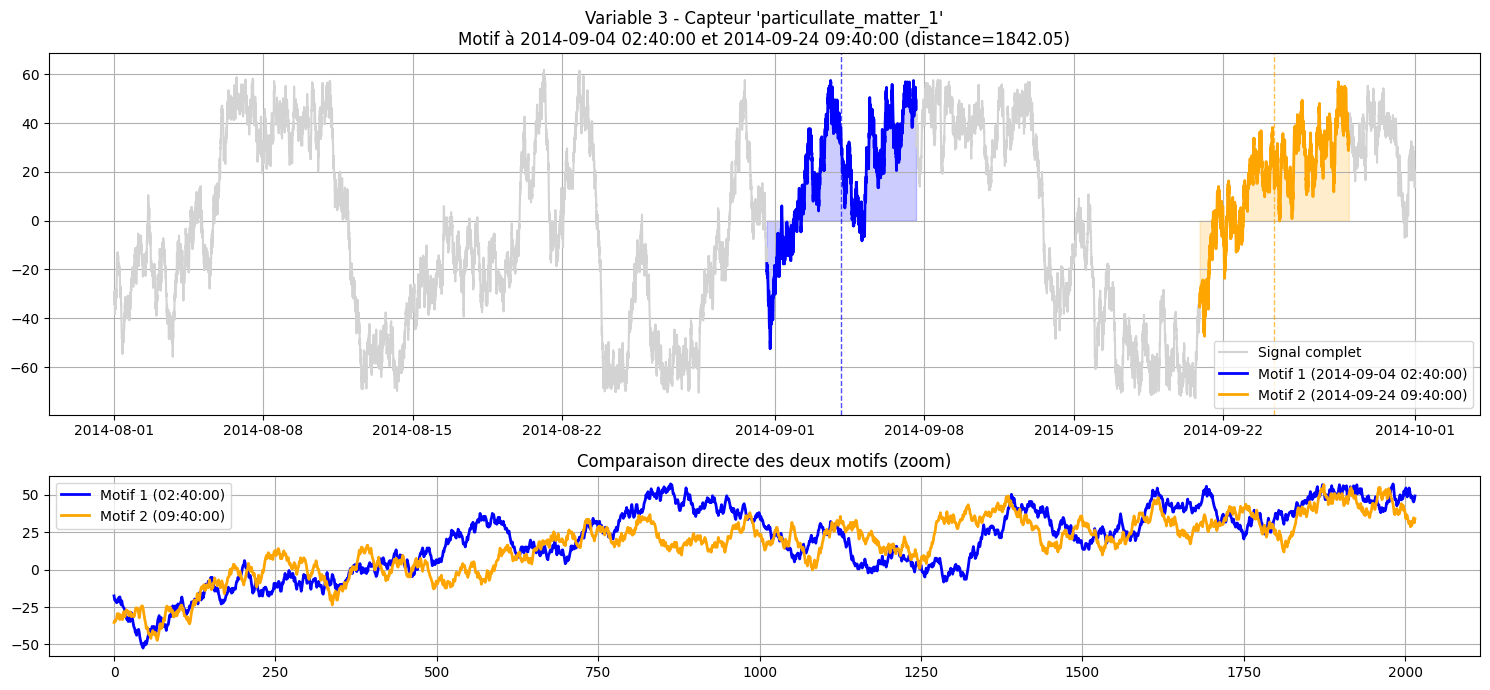

Variable 3 ('particullate_matter_1') : Motif à 2014-09-27 09:40:00 et 2014-09-07 23:40:00 (dist=1930.74)


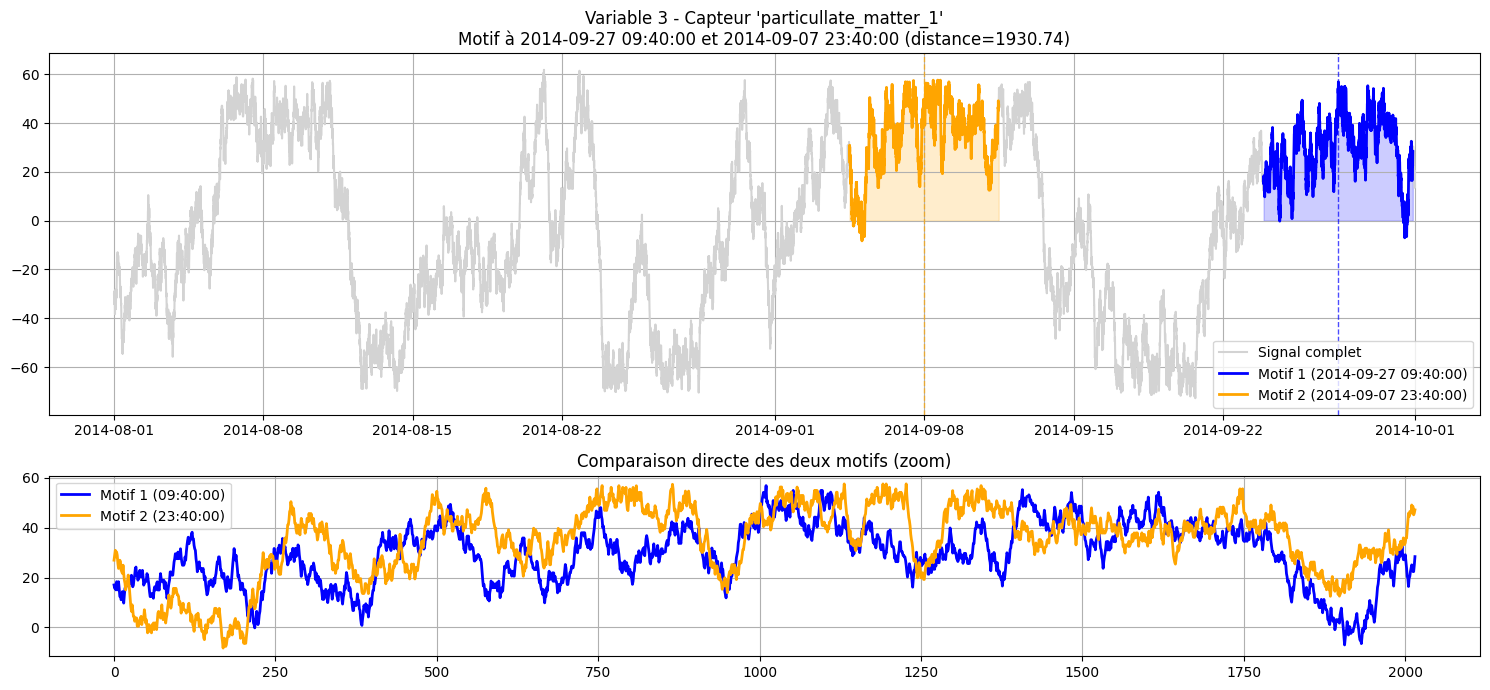

Variable 4 ('sulfure_dioxide_1') : Motif à 2014-09-09 15:30:00 et 2014-09-24 14:55:00 (dist=1934.10)


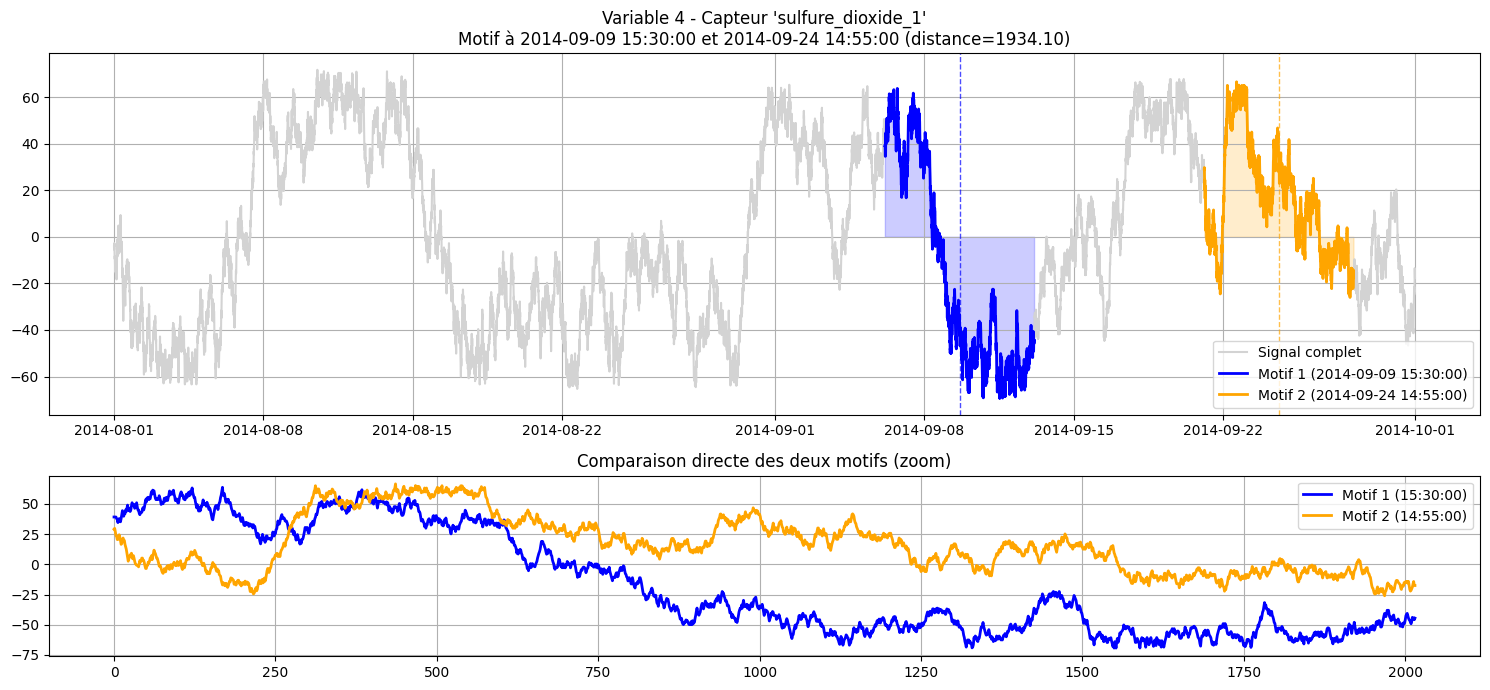

Variable 4 ('sulfure_dioxide_1') : Motif à 2014-09-02 01:00:00 et 2014-09-23 20:50:00 (dist=1945.42)


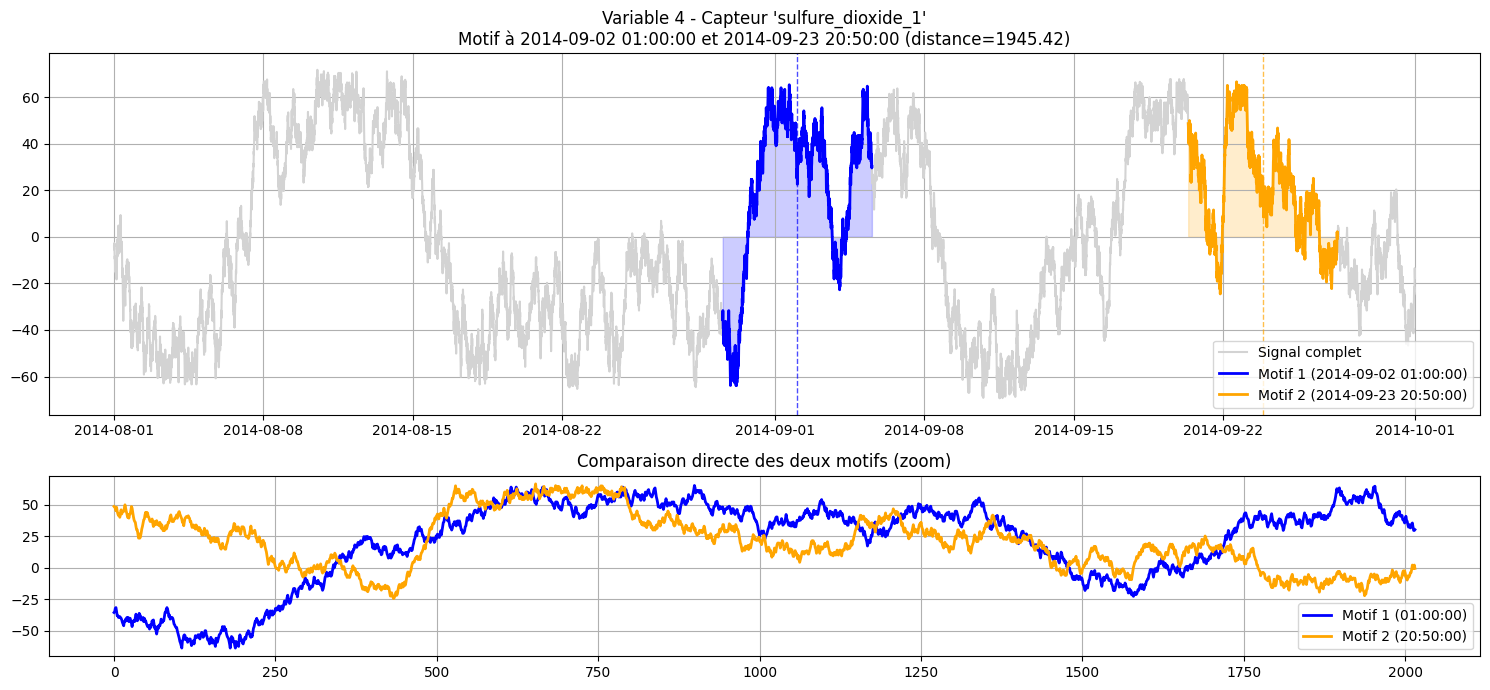

Variable 4 ('sulfure_dioxide_1') : Motif à 2014-09-21 08:35:00 et 2014-09-15 00:50:00 (dist=1977.87)


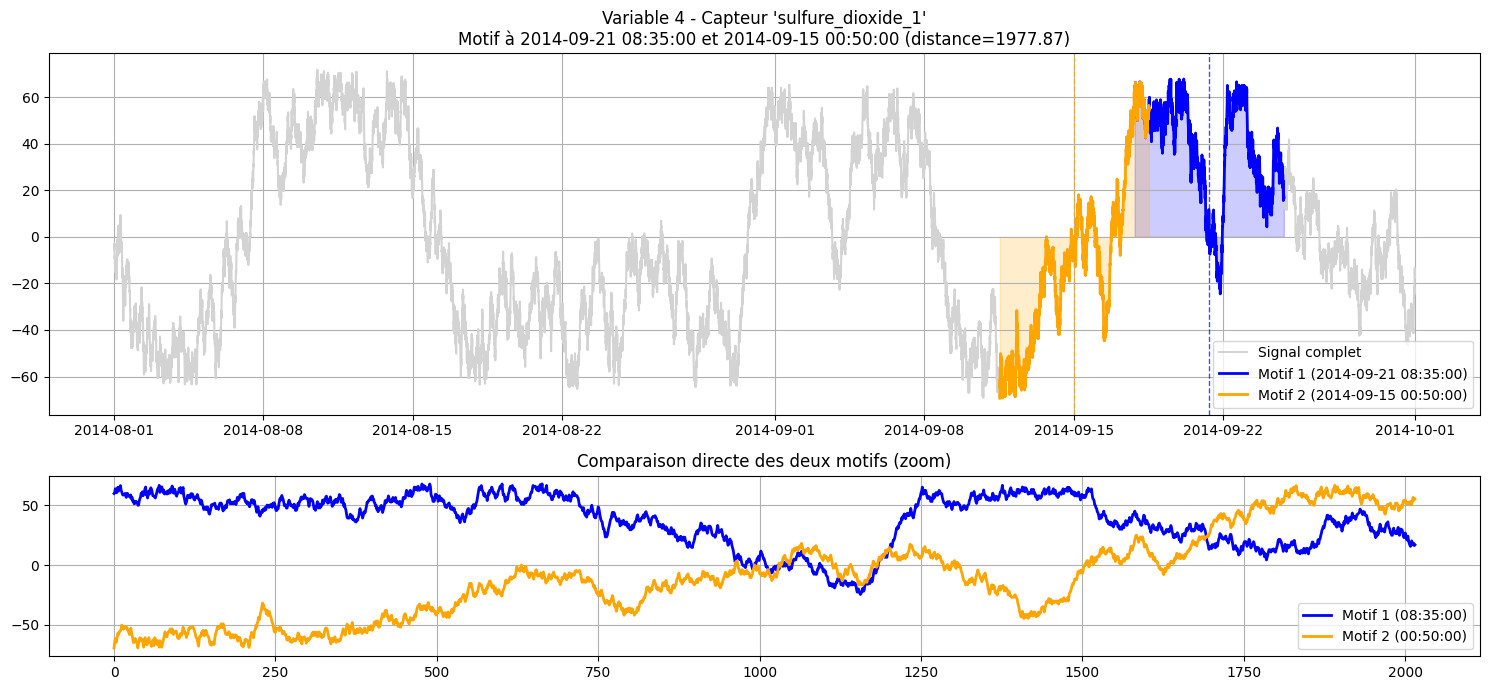

In [13]:
import matplotlib.pyplot as plt

def plot_motif_match(signal, idx1, idx2, window_size, t1, t2, var_idx, capteur_col, dist):
    # On prépare les fenêtres à afficher
    motif1 = signal.iloc[idx1 - window_size//2 : idx1 + window_size//2].values
    motif2 = signal.iloc[idx2 - window_size//2 : idx2 + window_size//2].values
    time1 = signal.index[idx1 - window_size//2 : idx1 + window_size//2]
    time2 = signal.index[idx2 - window_size//2 : idx2 + window_size//2]
    
    fig, axes = plt.subplots(2, 1, figsize=(15, 7), gridspec_kw={'height_ratios': [2, 1]})

    # 1. Courbe globale avec annotation des motifs
    axes[0].plot(signal.index, signal.values, color='lightgray', label="Signal complet")
    axes[0].plot(time1, motif1, color='blue', lw=2, label=f"Motif 1 ({t1})")
    axes[0].plot(time2, motif2, color='orange', lw=2, label=f"Motif 2 ({t2})")
    axes[0].axvline(signal.index[idx1], color='blue', ls='--', lw=1, alpha=0.7)
    axes[0].axvline(signal.index[idx2], color='orange', ls='--', lw=1, alpha=0.7)
    axes[0].set_title(f"Variable {var_idx} - Capteur '{capteur_col}'\nMotif à {t1} et {t2} (distance={dist:.2f})")
    axes[0].legend()
    axes[0].grid(True)
    # Annotation visuelle
    axes[0].fill_between(time1, motif1, color='blue', alpha=0.2)
    axes[0].fill_between(time2, motif2, color='orange', alpha=0.2)

    # 2. Superposition des deux motifs (zoom)
    axes[1].plot(range(len(motif1)), motif1, color='blue', lw=2, label=f"Motif 1 ({t1.time()})")
    axes[1].plot(range(len(motif2)), motif2, color='orange', lw=2, label=f"Motif 2 ({t2.time()})")
    axes[1].set_title("Comparaison directe des deux motifs (zoom)")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Boucle d'affichage sur tous les motifs trouvés pour chaque variable
window_size = 2016  # à adapter
for var_idx, (signal_df, prof) in enumerate(zip(pds_normalized, matrix_profiles)):
    capteur_col = signal_df.columns[1]    # colonne d'intérêt (ex: capteur 1)
    signal = signal_df[capteur_col]
    if not isinstance(signal.index, pd.DatetimeIndex):
        signal.index = pd.to_datetime(signal.index)
    motifs = extract_unique_motifs(prof, window_size=window_size, top_k=3)
    for t1, t2, dist in motifs:
        idx1 = signal.index.get_indexer([t1], method='nearest')[0]
        idx2 = signal.index.get_indexer([t2], method='nearest')[0]
        print(f"Variable {var_idx} ('{capteur_col}') : Motif à {t1} et {t2} (dist={dist:.2f})")
        plot_motif_match(signal, idx1, idx2, window_size, t1, t2, var_idx, capteur_col, dist)
